# HOTEL BUSINESS INSIGHT

## Introduction
Sangat penting bagi suatu perusahaan untuk selalu menganalisa performa bisnisnya. Pada kesempatan kali ini, kita akan lebih mendalami bisnis dalam bidang perhotelan. Fokus yang kita tuju adalah untuk mengetahui bagaimana perilaku pelanggan kita dalam melakukan pemesanan hotel, dan hubungannya terhadap tingkat pembatalan pemesanan hotel. Hasil dari insight yang kita temukan akan kita sajikan dalam bentuk data visualisasi agar lebih mudah dipahami dan bersifat lebih persuasif.

sumber code:
https://www.kaggle.com/code/shrutidandagi/hotel-booking-demand-eda-data-visualisation

## Importing Necessery Libraries and Dataset

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy
from scipy.stats import chi2_contingency 
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from statistics import stdev
from pprint import pprint
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
sns.set_context("notebook")

In [2]:
df = pd.read_csv('hotel_bookings_data.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_weekdays_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,Resort Hotel,0,342,2017,September,27,1,0,0,2,...,3,No Deposit,NaN,NaN,0,Personal,0.0,0,0,Check-Out
1,Resort Hotel,0,737,2017,September,27,1,0,0,2,...,4,No Deposit,NaN,NaN,0,Personal,0.0,0,0,Check-Out
2,Resort Hotel,0,7,2017,September,27,1,0,1,1,...,0,No Deposit,NaN,NaN,0,Personal,75.0,0,0,Check-Out
3,Resort Hotel,0,13,2017,September,27,1,0,1,1,...,0,No Deposit,304.0,NaN,0,Personal,75.0,0,0,Check-Out
4,Resort Hotel,0,14,2017,September,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Personal,98.0,0,1,Check-Out


### Data Cleaning

In [4]:
# Check Missing Value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_weekdays_nights        119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

terdapat beberapa feature yang memiliki data kosong, yaitu kolom `city`, `agent`, `company`, `children`

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_weekdays_nights               0
adults                                 0
children                               4
babies                                 0
meal                                   0
city                                 488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type   

### Handling missing Value

In [6]:
# missing value pada company dan agent akan diisi dengan nilai 0
df[['company','agent']]=df[['company','agent']].fillna(0)

In [7]:
# missing value pada city akan diisi dengan others
df[['city']]= df[['city']].fillna('others')

In [8]:
# missing value children akan diisi dengan mean
df[['children']]=df[['children']].fillna(df['children'].mean())

In [9]:
# dalam kolom meal terdapat 'undifined' yang sama artinya dengan 'SC', merubah 'undifined' menjadi 'SC'
df['meal'].replace('Undefined','SC', inplace=True)

In [10]:
df['meal'].value_counts()

Breakfast     92310
Dinner        14463
No Meal       10650
SC             1169
Full Board      798
Name: meal, dtype: int64

In [21]:
df['city'].value_counts()

Kota Denpasar              48483
Kabupaten Bangka           12120
Kota Yogyakarta            10401
Kota Batu                   8560
Kabupaten Bandung           7285
                           ...  
Kabupaten Malang               1
Kabupaten Bekasi               1
Kabupaten Barito Kuala         1
Kota Palembang                 1
Kabupaten Maluku Tengah        1
Name: city, Length: 178, dtype: int64

In [11]:
# membedakan paket dengan menggunakan meal dan tidak menggunakan meal
df['meal'] = df['meal'].replace(['Breakfast', 'Dinner', 'Full Board'], 'With_Meal')
df['meal'] = df['meal'].replace(['SC', 'No Meal'], 'Without_meal')

In [12]:
df['meal'].value_counts()

With_Meal       107571
Without_meal     11819
Name: meal, dtype: int64

In [13]:
(df['adults']+df['children']+df['babies']==0).value_counts()

False    119210
True        180
dtype: int64

In [14]:
# karena terdapat kolom yang memiliki 0 adults, 0 children dan 0 babies, jadi diasumsikan sebagai zero_guests dan akan didrop
zero_guests = list(df.loc[df['adults']+df['children']+df['babies']==0].index)
df.drop(df.index[zero_guests], inplace=True)

In [15]:
df.shape

(119210, 29)

In [16]:
df['is_canceled'].value_counts()

0    75011
1    44199
Name: is_canceled, dtype: int64

### EDA

In [17]:
fig=make_subplots(rows=1, cols=2, 
                  subplot_titles=("", "Jenis Hotel"),
                  specs=[[{"type": "bar"}, {"type": "pie"}]])

plot_df=df['is_canceled'].value_counts(normalize=True)
plot_df=plot_df.mul(100).rename('Percent').reset_index().sort_values('Percent')
plot_df.rename(columns={'index':'is_canceled'}, inplace=True)
plot_df['is_canceled']=['No Canceled' if i == '0' else 'Canceled' for i in plot_df['is_canceled']]
x=plot_df['is_canceled']
y=plot_df['Percent']
fig.add_trace(
    go.Bar(x=x, y=y, text=y,opacity=.8,
           hovertemplate='is_canceled<br>%{x}: %{y:.3}%<extra></extra>',
           showlegend=False), row=1, col=1)
fig.update_traces(texttemplate='%{text:.3s}%', textposition='outside', 
                  marker_line=dict(width=1, color='#1F0202'), marker_color=['#C02B34','#CDBBA7'])
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='gray')
fig.update_layout(yaxis_ticksuffix = '%')

# Pie chart
plot_df2=df
plot_df2=plot_df2['hotel'].value_counts(normalize=True)
plot_df2=plot_df2.mul(100).rename('Percent').reset_index().sort_values('Percent', ascending=False)
plot_df2.rename(columns={'index':'hotel'}, inplace=True)
fig.add_trace(go.Pie(labels=plot_df2['hotel'], values=plot_df2['Percent'], opacity=0.85, hole=0.4,
                     hovertemplate='%{label}<br>hotel: %{value:.3}%<extra></extra>',
                     marker_colors=['#587D65','#ADC4B2','#D1C9C2']), row=1, col=2)
fig.update_yaxes(tickmode = 'array', range=[0, 90], dtick=5)
fig.update_traces(textfont_size=14,textfont_color='black',marker=dict(line=dict(color='#28221D', width=1)))
fig.update_layout(title_text="Hotel Canceled and type of hotel", font_color='#28221D',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')      
fig.show()

kita dapat mengetahui bahwa `City Hotel` memiliki persentase lebih banyak daripada `Resort Hotel`

<module 'seaborn' from 'c:\\Users\\ASUS\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

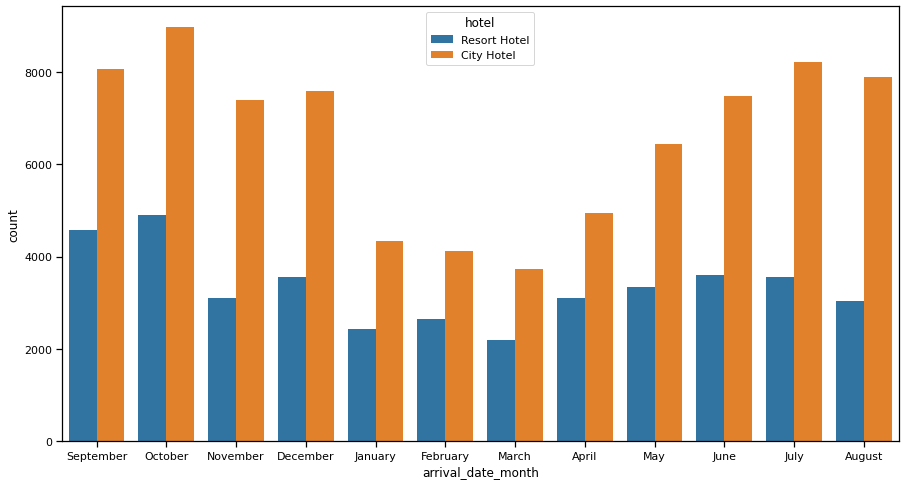

In [18]:
#selanjutnya kita ingin mengetahui, pada bulan apa perubahan jumlah pengunjung yang terjadi
plt.figure(figsize= (15,8))
sns.countplot(x='arrival_date_month', hue='hotel', data=df)
sns

In [19]:
#plot_df = df.groupby(['arrival_date_month', 'hotel'])['is_canceled'].value_counts()
#plot_df = plot_df.mul(100).rename('Percent').reset_index()
#fig = px.bar(plot_df, x='arrival_date_month', y='count' ,color='hotel', barmode='group')


plot_df = df.groupby(['arrival_date_month', 'hotel'])['is_canceled'].value_counts()
plot_df = plot_df.mul(1).rename('Percent').reset_index()
fig = px.bar(plot_df, x="arrival_date_month", y="Percent", color="is_canceled", barmode="group",
            text='Percent', opacity=.75,facet_col="hotel", category_orders={'is_canceled': ['0', '1']},
            color_discrete_map={'0': '#C02B34','1': '#CDBBA7'}) 
fig.update_traces(texttemplate='%{text:.3s}%', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'),  width=.4)
fig.update_layout(title_text='Jumlah Cancel Hotel perbulan', yaxis_ticksuffix = '',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',font_color='#28221D',
                  height=500, xaxis=dict(tickangle=30))
fig.update_xaxes(showticklabels=True,tickangle=30,col=2)
fig.update_yaxes(title = "", zeroline=True, zerolinewidth=1, zerolinecolor='#28221D')
fig.show()